In [12]:
!git clone https://github.com/marcusklasson/GroceryStoreDataset.git

Cloning into 'GroceryStoreDataset'...
remote: Enumerating objects: 6559, done.
remote: Counting objects: 100% (266/266), done.
remote: Compressing objects: 100% (231/231), done.
remote: Total 6559 (delta 45), reused 37 (delta 35), pack-reused 6293 (from 1)
Receiving objects: 100% (6559/6559), 116.26 MiB | 27.72 MiB/s, done.
Resolving deltas: 100% (275/275), done.


In [22]:
import numpy as np
from pathlib import Path
from PIL import Image, ImageOps, ImageEnhance
from typing import List, Tuple
import copy
import cv2
import torch
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import models, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

!pip install torchsummary
from torchsummary import summary
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [23]:
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())

2.4.0
12.3
True


In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [26]:
class GroceryStoreDataset(Dataset):

    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("GroceryStoreDataset/dataset")
        self.split = split # used for splitting the dataset in train and test
        self.paths, self.labels = self.read_file() #reading the labels and images

        self.transform = transform 

    def __len__(self) -> int: #get the number of elements in the dataset
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]: 
        img = Image.open(self.root / self.paths[idx])
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    # legge un file di testo che contiene i percorsi delle immagini e le etichette associate
    # restituisce due liste: una con percorsi delle immagini e una con le etichette
    def read_file(self) -> Tuple[List[str], List[int]]: #outputs a tuple
        paths = []
        labels = []

        with open(self.root / f"{self.split}.txt") as f:
            for line in f:
                # path, fine-grained class, coarse-grained class
                path, _, label = line.replace("\n", "").split(", ") #rimuove il carattere di nuova linea, e poi divide in 3 parti con virgola come separatore 
                paths.append(path), labels.append(int(label)) #salva solo percorsi ed etichette

        return paths, labels

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

In [28]:
mean = [0.5306, 0.3964, 0.2564]
std = [0.2293, 0.2060, 0.1746]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

train_dataset = GroceryStoreDataset(split="train", transform=transform)
test_dataset = GroceryStoreDataset(split="test", transform=transform)
val_dataset = GroceryStoreDataset(split="val", transform=transform)

## Part 2: fine-tune an existing network

Your goal is to fine-tune a pretrained **ResNet-18** model on `GroceryStoreDataset`. Use the implementation provided by PyTorch, do not implement it yourselves! (i.e. exactly what you **could not** do in the first part of the assignment). Specifically, you must use the PyTorch ResNet-18 model pretrained on ImageNet-1K (V1). Divide your fine-tuning into two parts:

1. First, fine-tune the Resnet-18 with the same training hyperparameters you used for your best model in the first part of the assignment.

In [54]:
model = models.resnet18(weights='IMAGENET1K_V1')

# The final layer is modified to have 43 classes as output
num_classes = 43
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

In [55]:
# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.0001)

# learning rate scheduler
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

batch_size = 32
num_epochs = 30
patience = 7

In [38]:
# Training function
def train_model(model, train_loader, val_loader, num_epochs, patience, optimizer, loss_fn, scheduler):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    early_stop_counter = 0

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        epoch_train_loss = 0.0
        epoch_train_acc = 0.0
        epoch_val_loss = 0.0
        epoch_val_acc = 0.0

        # Training phase
        model.train() 
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            _, preds = torch.max(outputs, 1)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = running_corrects.double() / len(train_loader.dataset)

        # Validation phase
        model.eval()   
        running_loss = 0.0
        running_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                _, preds = torch.max(outputs, 1)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

        epoch_val_loss = running_loss / len(val_loader.dataset)
        epoch_val_acc = running_corrects.double() / len(val_loader.dataset)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f'Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | '
              f'Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')

        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc.item())
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc.item())

        if epoch_val_loss <= best_loss:
            best_loss = epoch_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print("Early stopping triggered")
            break

        scheduler.step()

    print(f'Minimum val loss: {best_loss:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, train_accuracies, val_losses, val_accuracies


In [41]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

Epoch [1/30], Train Loss: 1.5396 Acc: 0.6545 | Val Loss: 0.9794 Acc: 0.7568
Epoch [2/30], Train Loss: 0.2360 Acc: 0.9792 | Val Loss: 0.7365 Acc: 0.8176
Epoch [3/30], Train Loss: 0.0785 Acc: 0.9951 | Val Loss: 0.6128 Acc: 0.8682
Epoch [4/30], Train Loss: 0.0338 Acc: 1.0000 | Val Loss: 0.5895 Acc: 0.8311
Epoch [5/30], Train Loss: 0.0195 Acc: 0.9996 | Val Loss: 0.5194 Acc: 0.8750
Epoch [6/30], Train Loss: 0.0129 Acc: 1.0000 | Val Loss: 0.5336 Acc: 0.8716
Epoch [7/30], Train Loss: 0.0105 Acc: 1.0000 | Val Loss: 0.5065 Acc: 0.8750
Epoch [8/30], Train Loss: 0.0078 Acc: 1.0000 | Val Loss: 0.4871 Acc: 0.8750
Epoch [9/30], Train Loss: 0.0087 Acc: 1.0000 | Val Loss: 0.5021 Acc: 0.8682
Epoch [10/30], Train Loss: 0.0077 Acc: 1.0000 | Val Loss: 0.4892 Acc: 0.8716
Epoch [11/30], Train Loss: 0.0078 Acc: 0.9996 | Val Loss: 0.4872 Acc: 0.8818
Epoch [12/30], Train Loss: 0.0068 Acc: 1.0000 | Val Loss: 0.4704 Acc: 0.8818
Epoch [13/30], Train Loss: 0.0077 Acc: 1.0000 | Val Loss: 0.4775 Acc: 0.8784
Epoch [1

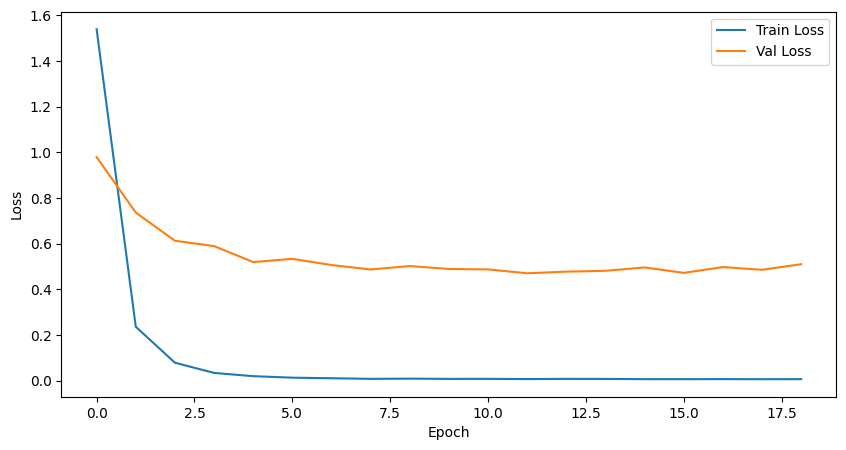

In [42]:
model, train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, val_loader, num_epochs, patience, optimizer, loss_fn, scheduler)

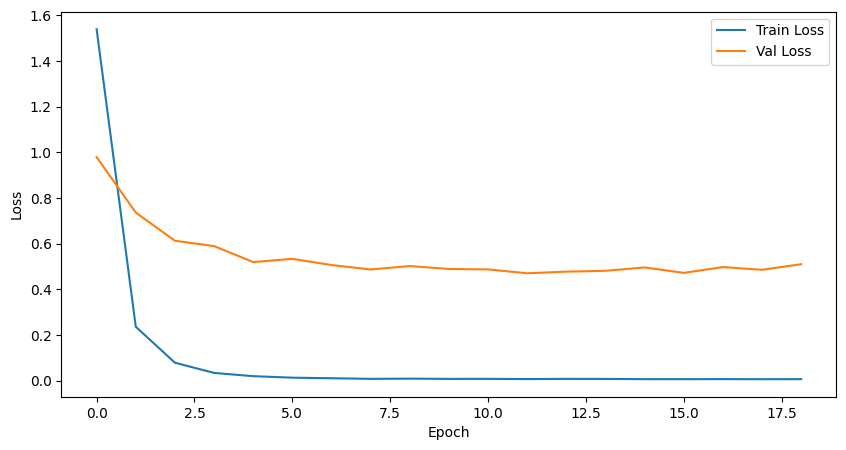

In [44]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

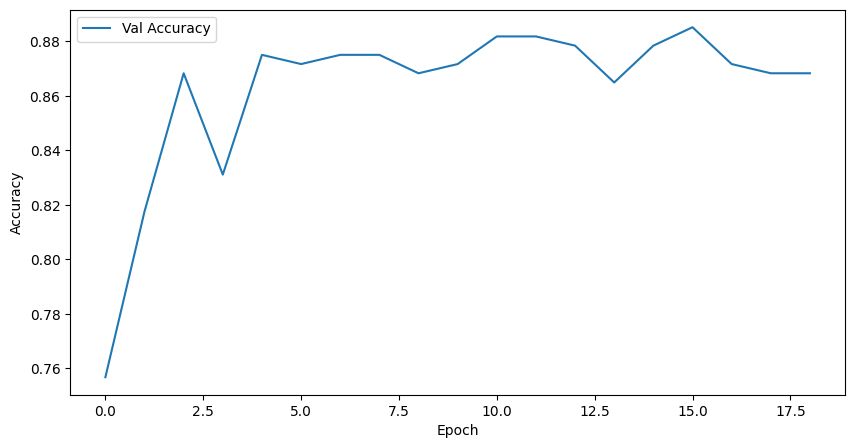

In [45]:
# Plot the validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

2. Then, tweak the training hyperparameters in order to increase the accuracy on the validation split of `GroceryStoreDataset`. Justify your choices by analyzing the training plots and/or citing sources that guided you in your decisions (papers, blog posts, YouTube videos, or whatever else you find enlightening). You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split **between 80 and 90%**.

### EXPERIMENT 1 - EXPLOITATION OF CYCLICAL LEARNING RATES

> Training with cyclical learning rates instead of fixed values achieves improved classification accuracy without a need to tune and often in fewer iterations.>

Source: [Smith - Cyclical Learning Rates for Training Neural Networks](http://arxiv.org/abs/1506.01186)

The proposed scheduler, specifically, changes the learning rate according to the 1cycle policy, described in [Smith, Topin - Super-Convergence: Very Fast Training of Neural Networks Using Large Learning Rates](http://arxiv.org/abs/1708.07120)

In [69]:
model = models.resnet18(weights='IMAGENET1K_V1')

# The final layer is modified to have 43 classes as output
num_classes = 43
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

In [65]:
# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.0001)

batch_size = 32
num_epochs = 30
patience = 7

# new learning rate scheduler
one_cycle_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, steps_per_epoch=len(train_loader), epochs=num_epochs)

In [66]:
model, train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, val_loader, num_epochs, patience, optimizer, loss_fn, one_cycle_scheduler)

Epoch [1/30], Train Loss: 2.3028 Acc: 0.4606 | Val Loss: 1.8951 Acc: 0.5236
Epoch [2/30], Train Loss: 0.8513 Acc: 0.8511 | Val Loss: 1.3504 Acc: 0.6554
Epoch [3/30], Train Loss: 0.3874 Acc: 0.9595 | Val Loss: 1.0187 Acc: 0.7500
Epoch [4/30], Train Loss: 0.1822 Acc: 0.9936 | Val Loss: 0.8575 Acc: 0.7736
Epoch [5/30], Train Loss: 0.0996 Acc: 0.9970 | Val Loss: 0.7662 Acc: 0.8007
Epoch [6/30], Train Loss: 0.0589 Acc: 1.0000 | Val Loss: 0.7200 Acc: 0.8041
Epoch [7/30], Train Loss: 0.0412 Acc: 1.0000 | Val Loss: 0.7086 Acc: 0.7872
Epoch [8/30], Train Loss: 0.0308 Acc: 1.0000 | Val Loss: 0.7105 Acc: 0.7939
Epoch [9/30], Train Loss: 0.0232 Acc: 1.0000 | Val Loss: 0.6711 Acc: 0.7905
Epoch [10/30], Train Loss: 0.0189 Acc: 1.0000 | Val Loss: 0.6557 Acc: 0.8108
Epoch [11/30], Train Loss: 0.0182 Acc: 1.0000 | Val Loss: 0.5919 Acc: 0.8176
Epoch [12/30], Train Loss: 0.0148 Acc: 1.0000 | Val Loss: 0.6500 Acc: 0.8041
Epoch [13/30], Train Loss: 0.0119 Acc: 1.0000 | Val Loss: 0.6313 Acc: 0.8176
Epoch [1

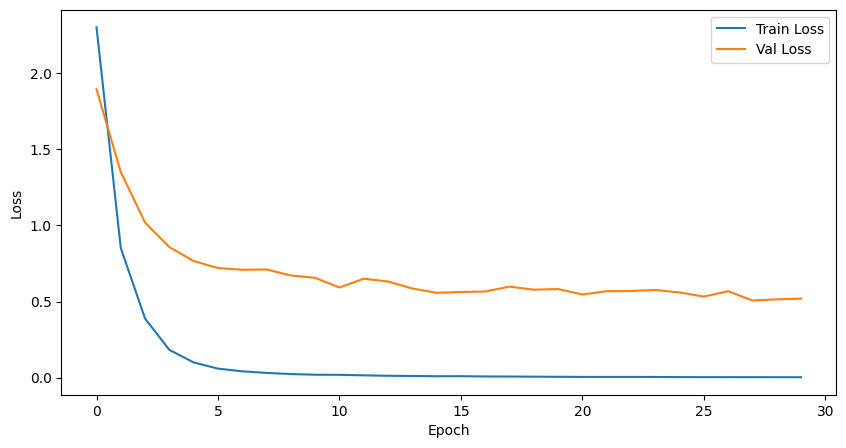

In [67]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

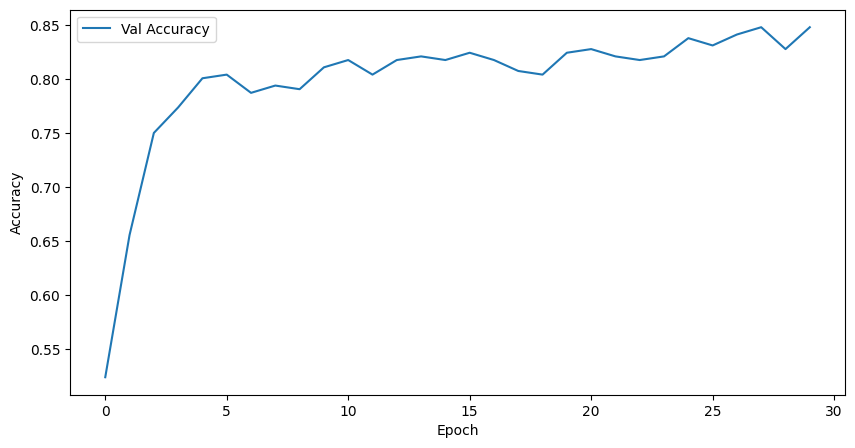

In [68]:
# Plot the validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### EXPERIMENT 2 - EXPLOITATION OF DIFFERENT OPTIMIZERS

In this experiment, different optimizers are exploited in the attempt of achieving better performances in terms of accuracy on the validation split:
* [SDG optimizer with momentum](http://pytorch.org/docs/stable/generated/torch.optim.SGD.html)
* [Adagrad](http://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html)
* [NAG](http://mitliagkas.github.io/ift6085-2019/ift-6085-lecture-6-notes.pdf)
* [AdamW](http://https://pytorch.org/docs/stable/generated/torch.optim.AdamW)
* [RAdam](https://pytorch.org/docs/stable/generated/torch.optim.RAdam)

**SDG optimizer with momentum**

In [87]:
model = models.resnet18(weights='IMAGENET1K_V1')

# The final layer is modified to have 43 classes as output
num_classes = 43
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

In [88]:
# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)

# learning rate scheduler
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

batch_size = 32
num_epochs = 30
patience = 7

In [89]:
model, train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, val_loader, num_epochs, patience, optimizer, loss_fn, one_cycle_scheduler)

Epoch [1/30], Train Loss: 2.4999 Acc: 0.4011 | Val Loss: 2.0359 Acc: 0.4730
Epoch [2/30], Train Loss: 1.1031 Acc: 0.7682 | Val Loss: 1.3509 Acc: 0.6723
Epoch [3/30], Train Loss: 0.5526 Acc: 0.9246 | Val Loss: 1.0631 Acc: 0.7568
Epoch [4/30], Train Loss: 0.3283 Acc: 0.9670 | Val Loss: 0.8736 Acc: 0.7736
Epoch [5/30], Train Loss: 0.2036 Acc: 0.9875 | Val Loss: 0.7743 Acc: 0.8176
Epoch [6/30], Train Loss: 0.1430 Acc: 0.9917 | Val Loss: 0.7274 Acc: 0.7770
Epoch [7/30], Train Loss: 0.0998 Acc: 0.9966 | Val Loss: 0.6613 Acc: 0.8209
Epoch [8/30], Train Loss: 0.0757 Acc: 0.9981 | Val Loss: 0.6314 Acc: 0.8209
Epoch [9/30], Train Loss: 0.0629 Acc: 0.9985 | Val Loss: 0.6246 Acc: 0.8581
Epoch [10/30], Train Loss: 0.0513 Acc: 0.9992 | Val Loss: 0.6139 Acc: 0.8311
Epoch [11/30], Train Loss: 0.0415 Acc: 1.0000 | Val Loss: 0.5846 Acc: 0.8412
Epoch [12/30], Train Loss: 0.0377 Acc: 1.0000 | Val Loss: 0.5606 Acc: 0.8378
Epoch [13/30], Train Loss: 0.0357 Acc: 1.0000 | Val Loss: 0.5689 Acc: 0.8311
Epoch [1

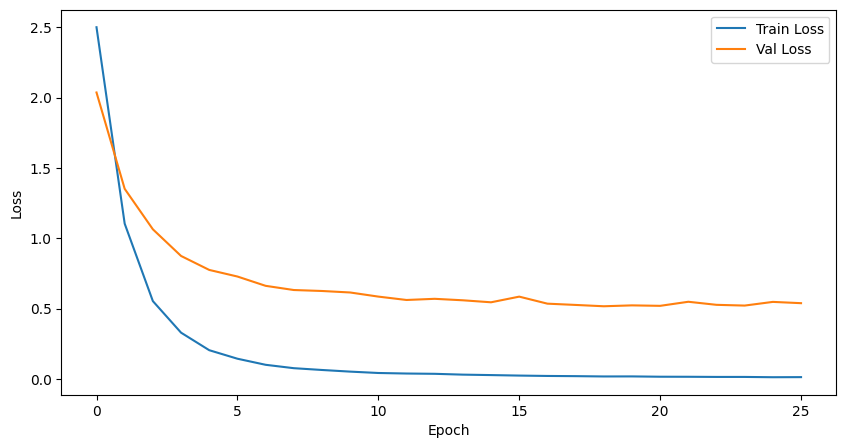

In [90]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

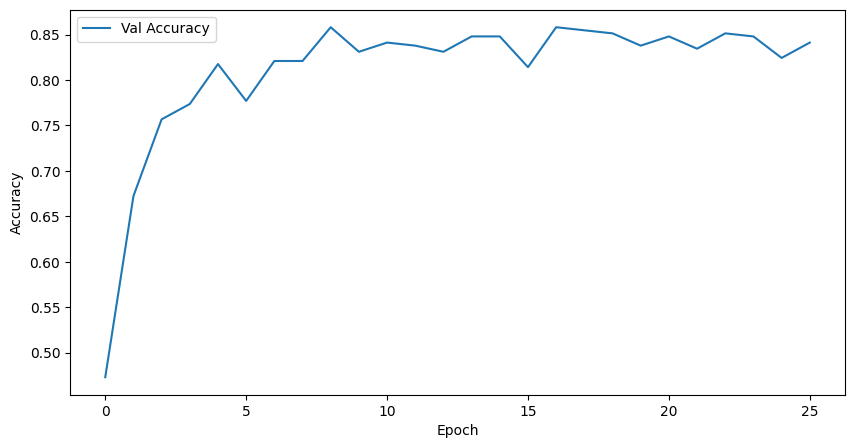

In [91]:
# Plot the validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**Adagrad optimizer**

In [92]:
model = models.resnet18(weights='IMAGENET1K_V1')

# The final layer is modified to have 43 classes as output
num_classes = 43
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

In [93]:
# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.Adagrad(model.parameters(), lr=0.001, weight_decay=0.0001)

# learning rate scheduler
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

batch_size = 32
num_epochs = 30
patience = 7

In [94]:
model, train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, val_loader, num_epochs, patience, optimizer, loss_fn, one_cycle_scheduler)

Epoch [1/30], Train Loss: 0.8132 Acc: 0.8167 | Val Loss: 0.7970 Acc: 0.7872
Epoch [2/30], Train Loss: 0.0917 Acc: 0.9955 | Val Loss: 0.6028 Acc: 0.8514
Epoch [3/30], Train Loss: 0.0422 Acc: 0.9992 | Val Loss: 0.6924 Acc: 0.8345
Epoch [4/30], Train Loss: 0.0247 Acc: 0.9996 | Val Loss: 0.5631 Acc: 0.8378
Epoch [5/30], Train Loss: 0.0191 Acc: 1.0000 | Val Loss: 0.5370 Acc: 0.8412
Epoch [6/30], Train Loss: 0.0155 Acc: 1.0000 | Val Loss: 0.5108 Acc: 0.8615
Epoch [7/30], Train Loss: 0.0130 Acc: 1.0000 | Val Loss: 0.5314 Acc: 0.8446
Epoch [8/30], Train Loss: 0.0105 Acc: 1.0000 | Val Loss: 0.5064 Acc: 0.8649
Epoch [9/30], Train Loss: 0.0090 Acc: 1.0000 | Val Loss: 0.5385 Acc: 0.8176
Epoch [10/30], Train Loss: 0.0088 Acc: 1.0000 | Val Loss: 0.5041 Acc: 0.8547
Epoch [11/30], Train Loss: 0.0068 Acc: 1.0000 | Val Loss: 0.5078 Acc: 0.8514
Epoch [12/30], Train Loss: 0.0066 Acc: 1.0000 | Val Loss: 0.4938 Acc: 0.8547
Epoch [13/30], Train Loss: 0.0065 Acc: 1.0000 | Val Loss: 0.5029 Acc: 0.8412
Epoch [1

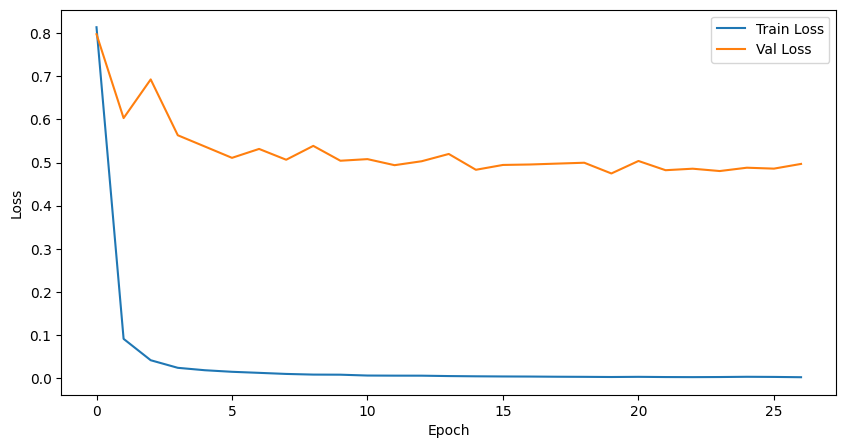

In [95]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

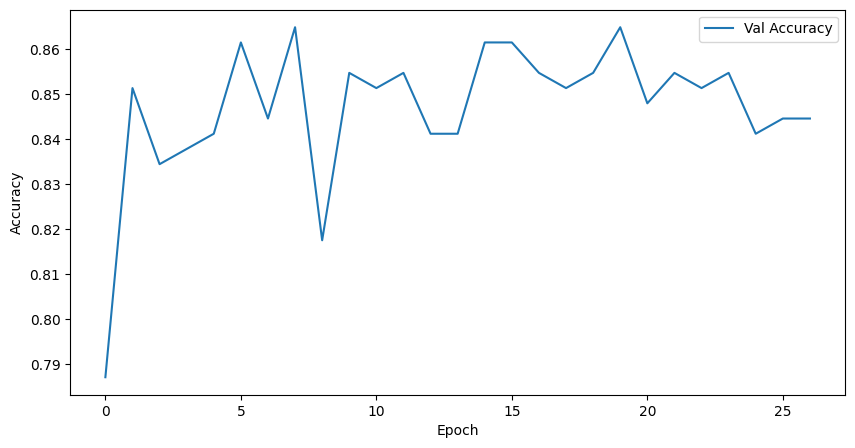

In [96]:
# Plot the validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**NAG optimizer**

In [104]:
model = models.resnet18(weights='IMAGENET1K_V1')

# The final layer is modified to have 43 classes as output
num_classes = 43
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

In [105]:
# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, nesterov=True, weight_decay=0.0001)

# learning rate scheduler
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

batch_size = 32
num_epochs = 30
patience = 7

In [106]:
model, train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, val_loader, num_epochs, patience, optimizer, loss_fn, one_cycle_scheduler)

Epoch [1/30], Train Loss: 2.4499 Acc: 0.4129 | Val Loss: 1.9339 Acc: 0.5372
Epoch [2/30], Train Loss: 1.0843 Acc: 0.7644 | Val Loss: 1.3262 Acc: 0.6351
Epoch [3/30], Train Loss: 0.5734 Acc: 0.9110 | Val Loss: 0.9861 Acc: 0.7568
Epoch [4/30], Train Loss: 0.3309 Acc: 0.9636 | Val Loss: 0.8246 Acc: 0.7939
Epoch [5/30], Train Loss: 0.2062 Acc: 0.9883 | Val Loss: 0.7654 Acc: 0.7905
Epoch [6/30], Train Loss: 0.1430 Acc: 0.9943 | Val Loss: 0.6878 Acc: 0.7973
Epoch [7/30], Train Loss: 0.1056 Acc: 0.9955 | Val Loss: 0.6585 Acc: 0.7973
Epoch [8/30], Train Loss: 0.0802 Acc: 0.9962 | Val Loss: 0.6264 Acc: 0.8041
Epoch [9/30], Train Loss: 0.0594 Acc: 0.9992 | Val Loss: 0.6005 Acc: 0.8345
Epoch [10/30], Train Loss: 0.0501 Acc: 0.9989 | Val Loss: 0.5918 Acc: 0.8108
Epoch [11/30], Train Loss: 0.0431 Acc: 1.0000 | Val Loss: 0.5592 Acc: 0.8277
Epoch [12/30], Train Loss: 0.0349 Acc: 1.0000 | Val Loss: 0.5507 Acc: 0.8277
Epoch [13/30], Train Loss: 0.0319 Acc: 0.9996 | Val Loss: 0.5529 Acc: 0.8311
Epoch [1

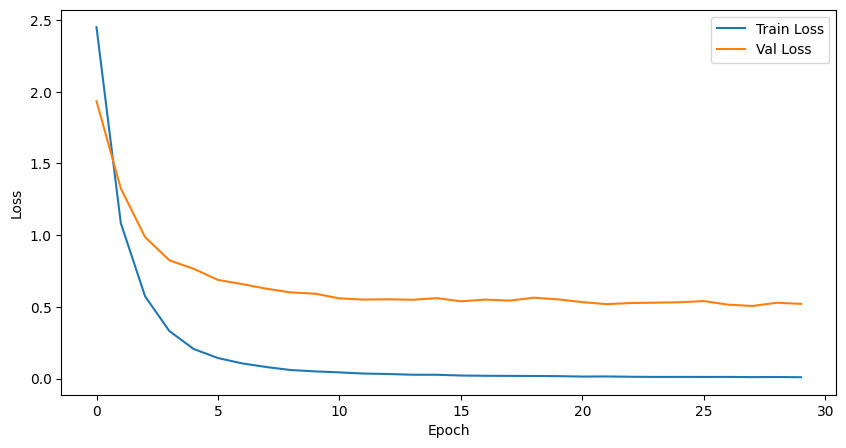

In [107]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

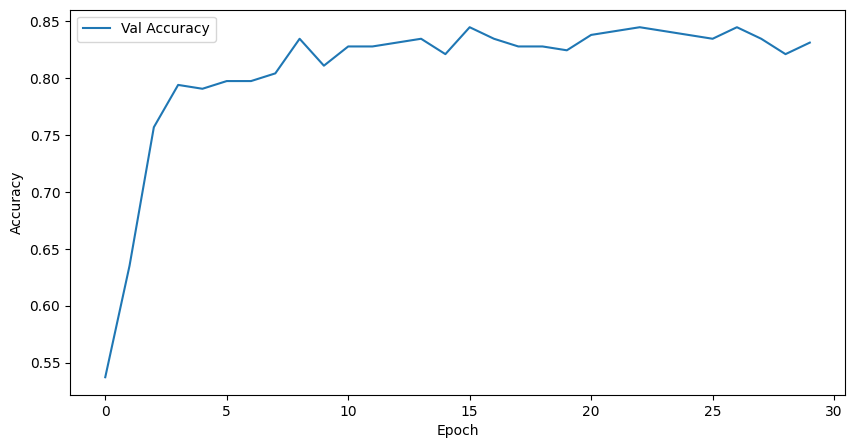

In [108]:
# Plot the validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**AdamW optimizer**

In [109]:
model = models.resnet18(weights='IMAGENET1K_V1')

# The final layer is modified to have 43 classes as output
num_classes = 43
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

In [110]:
# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.0001)

# learning rate scheduler
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

batch_size = 32
num_epochs = 30
patience = 7

In [111]:
model, train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, val_loader, num_epochs, patience, optimizer, loss_fn, one_cycle_scheduler)

Epoch [1/30], Train Loss: 1.5118 Acc: 0.6519 | Val Loss: 1.0405 Acc: 0.7264
Epoch [2/30], Train Loss: 0.2264 Acc: 0.9773 | Val Loss: 0.7001 Acc: 0.8243
Epoch [3/30], Train Loss: 0.0750 Acc: 0.9966 | Val Loss: 0.6270 Acc: 0.8311
Epoch [4/30], Train Loss: 0.0312 Acc: 1.0000 | Val Loss: 0.5432 Acc: 0.8581
Epoch [5/30], Train Loss: 0.0173 Acc: 1.0000 | Val Loss: 0.5204 Acc: 0.8547
Epoch [6/30], Train Loss: 0.0136 Acc: 1.0000 | Val Loss: 0.5082 Acc: 0.8615
Epoch [7/30], Train Loss: 0.0103 Acc: 1.0000 | Val Loss: 0.5091 Acc: 0.8412
Epoch [8/30], Train Loss: 0.0075 Acc: 1.0000 | Val Loss: 0.4814 Acc: 0.8649
Epoch [9/30], Train Loss: 0.0067 Acc: 1.0000 | Val Loss: 0.4663 Acc: 0.8547
Epoch [10/30], Train Loss: 0.0056 Acc: 1.0000 | Val Loss: 0.4618 Acc: 0.8514
Epoch [11/30], Train Loss: 0.0043 Acc: 1.0000 | Val Loss: 0.4698 Acc: 0.8412
Epoch [12/30], Train Loss: 0.0034 Acc: 1.0000 | Val Loss: 0.4793 Acc: 0.8480
Epoch [13/30], Train Loss: 0.0035 Acc: 0.9996 | Val Loss: 0.4848 Acc: 0.8514
Epoch [1

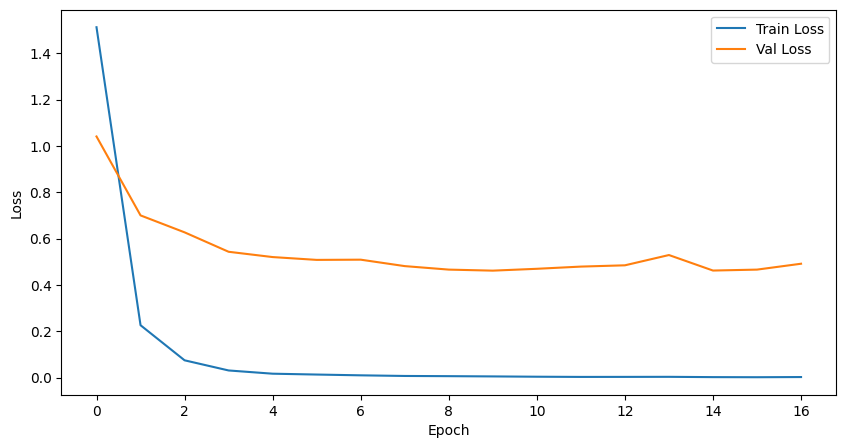

In [112]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

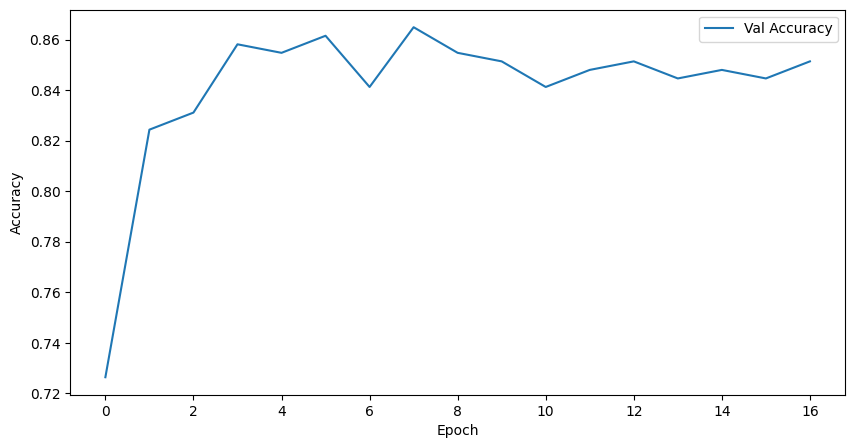

In [113]:
# Plot the validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**RAdam optimizer**

In [115]:
model = models.resnet18(weights='IMAGENET1K_V1')

# The final layer is modified to have 43 classes as output
num_classes = 43
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

In [117]:
# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.RAdam(model.parameters(), lr=0.0001, weight_decay=0.0001)

# learning rate scheduler
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

batch_size = 32
num_epochs = 30
patience = 7

In [118]:
model, train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, val_loader, num_epochs, patience, optimizer, loss_fn, one_cycle_scheduler)

Epoch [1/30], Train Loss: 3.4820 Acc: 0.1561 | Val Loss: 2.8282 Acc: 0.3412
Epoch [2/30], Train Loss: 1.9051 Acc: 0.6034 | Val Loss: 1.9312 Acc: 0.5135
Epoch [3/30], Train Loss: 0.9887 Acc: 0.8405 | Val Loss: 1.4010 Acc: 0.6554
Epoch [4/30], Train Loss: 0.5082 Acc: 0.9390 | Val Loss: 1.0859 Acc: 0.7770
Epoch [5/30], Train Loss: 0.2662 Acc: 0.9826 | Val Loss: 0.8753 Acc: 0.8074
Epoch [6/30], Train Loss: 0.1446 Acc: 0.9981 | Val Loss: 0.7653 Acc: 0.8074
Epoch [7/30], Train Loss: 0.0833 Acc: 0.9985 | Val Loss: 0.7186 Acc: 0.8108
Epoch [8/30], Train Loss: 0.0545 Acc: 0.9996 | Val Loss: 0.6734 Acc: 0.8311
Epoch [9/30], Train Loss: 0.0368 Acc: 1.0000 | Val Loss: 0.6415 Acc: 0.8514
Epoch [10/30], Train Loss: 0.0284 Acc: 1.0000 | Val Loss: 0.6388 Acc: 0.8311
Epoch [11/30], Train Loss: 0.0220 Acc: 1.0000 | Val Loss: 0.6215 Acc: 0.8311
Epoch [12/30], Train Loss: 0.0173 Acc: 0.9996 | Val Loss: 0.6041 Acc: 0.8446
Epoch [13/30], Train Loss: 0.0138 Acc: 1.0000 | Val Loss: 0.5879 Acc: 0.8514
Epoch [1

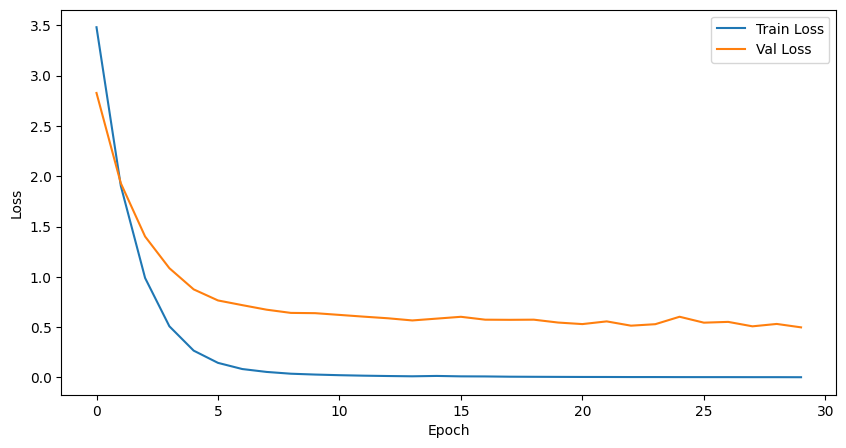

In [119]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

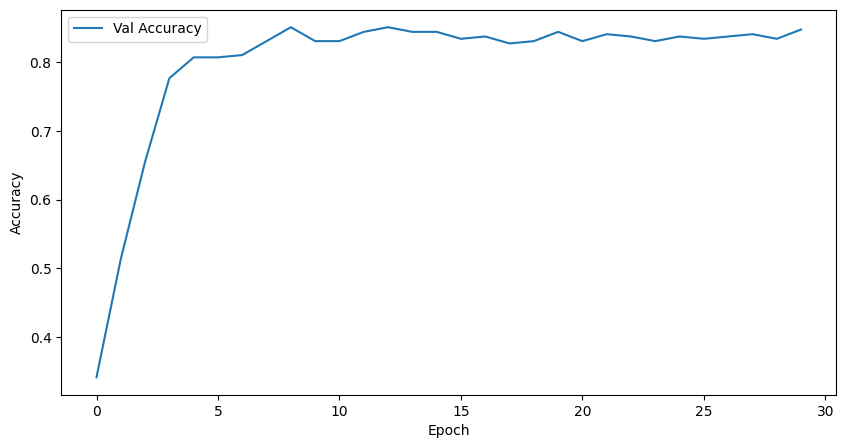

In [120]:
# Plot the validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

ALTRI ESPERIMENTI: 
1. Tenta Weight Decays diversi nella prima configurazione dell'Optimizer: https://arxiv.org/abs/1711.05101
2. Batch Size - Try different batch sizes. Smaller batch sizes can provide more regular updates, while larger batch sizes can provide more stable gradients: https://arxiv.org/abs/1609.04836
3. Aggiungi altri Schedulers - Use different learning rate schedulers like Cosine Annealing, ReduceLROnPlateau: https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
4. Cambia Patience per Early Stopping - Implement early stopping with different patience values to prevent overfitting: 